In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
import scipy.interpolate
import time
from scipy.signal import savgol_filter
import copy

In [2]:
superhist = "histdataset1.pkl"
with open(superhist, "rb") as f:
    ds = pkl.load(f)

keys = ds.keys()
print(keys)

#in making the superhistogram, I only saved the data between 26500 and 103000 (see makehist line 237) 
#making the first bin 26500 as the left edge 

countarr = ds["C10"] #strictly the compiled im_arr of all the images 
mbins = np.arange(26500, 26500+len(countarr)) #built into the dataset 

#choose to start the data at 30k, but since the cubic spline interpolation does a poor job outside datapoints 
#the first datapoint would be at 30,000.5, and would cause issue in 30k-30,000.5

start = np.argwhere(mbins == 29999) 

termcountarr = countarr[start[0][0]:] #this starts histogram at 29,999
termbins = mbins[start[0][0]:] #this is the adc codes which this is valid for

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])


In [3]:
def examineinl(edges, binsnum, edgemethodname): #here binsnum is binnumbers 
    idealmids = 0.5 + binsnum
    adcmids = [sum(i) for i in zip(edges[1:], edges[:-1])] #add together elements
    adcmids[:] = [x / 2 for x in adcmids] #find their mean, verified 3 entires, sufficient
    arraymids = np.array(adcmids)*(-1) 
    inl = [sum(i) for i in zip(idealmids, arraymids)]
    plt.plot(binsnum, inl, color='black', label='inl')
    plt.title(f'{edgemethodname} inl by bin number')
    plt.xlabel("bin number")
    plt.ylabel("inl")
    plt.legend()
    plt.grid()
    return inl 

def makenarrow(bcvar, right, left):
    width = right - left
    width *= (1-bcvar) #reduce the width of the bin 
    right = width + left 
    bcvar *= 0.85 #make the change amount reduced by 85% 
    return right, bcvar
    
def makewide(bcvar, right, left): #function increases the bin width 
    width = right - left
    width *= (1+bcvar) #increase the width of the bin 
    right = width + left 
    bcvar *= 0.85 
    return right, bcvar


## Cumulative sum binning

In [4]:
def makeedges(counts, spline):
    edges = [30000]
    for a in range(len(counts)):
        left = edges[-1]
        if left > 102999.5: #prevent interpolation beyond what we have for bins
            break
        Fr = counts[a] + spline(left) #F(r)= cs(right),

        right = left + 1 #standard bin width = 1
        cv = spline(right) #current value, based on current right edge
        
        bcvar = 0.25 #bin change variable (start with 25% change)  
        
        while len(edges) != a+2: 
            if Fr-0.01 < cv < Fr +0.01: #specify the requirement
                edges.append(right)
            
            elif cv < Fr: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                cv = spline(right)
            
            elif cv > Fr:  #bin is too big, reduce right edge
                right, bcvar = makenarrow(bcvar, right, left)
                cv = spline(right)
    return edges

In [5]:
smoothed = savgol_filter(termcountarr, 33, 3)
cumulsum = np.cumsum(smoothed)
#take the bin values to be at the center of the bin
cs = scipy.interpolate.CubicSpline(termbins +0.5, cumulsum) #spline fitting for the cumulative values 
csx = np.arange(29999, 29999+len(termbins), 0.1)

In [6]:
smoothedsum = cumulsum[-1] #the last element is the total 
countsum = sum(termcountarr) #add all elements together 
print(smoothedsum - countsum)

-986.2974393963814


In [7]:
start = time.time()
edges = makeedges(termcountarr[1:], cs) #exclude 29999 to start the array at 30k
end = time.time()
print("the runtime is:", end - start)

the runtime is: 22.869539976119995


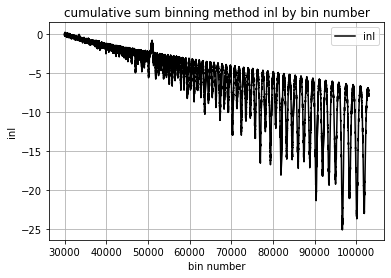

In [8]:
inlbins = 30000 + np.arange(0, len(edges)-1)
inl = examineinl(edges, inlbins, "cumulative sum binning method")

note that this looks surprisingly like a previous inl plot when I fit a spline to the termcountarr then used the integration method (seen below, but below I use it properly on the filtered array).

## Integrate edges binning
(for reference) investigate spline fitting method 2 

In [9]:
csint = scipy.interpolate.CubicSpline(termbins +0.5, smoothed)

In [18]:
def buildedges(cs, counts): #reduces
    edges = [30000] #define the first edge to be 30k 
    for a in range(len(counts)): 
        left = edges[-1]
        if left > 103000: #prevent interpolation beyond what we have for values
            break
        inte = cs.integrate(left, left+1) #generically make the width = 1        
        right = left + 1 
        bcvar = 0.25 #bin change variable (start with 25% change)
        while len(edges) != a+2: 
            if counts[a]-0.01 < inte < counts[a] +0.01: #make the requirement sufficient
                edges.append(right)  
            elif counts[a] > inte: #bin is too small, widen right edge
                right, bcvar = makewide(bcvar, right, left)
                inte = cs.integrate(left, right)       
            elif counts[a] < inte:  #bin is too big
                right, bcvar = makenarrow(bcvar, right, left)
                inte = cs.integrate(left, right)
    return edges

In [11]:
st = time.time()
intedges = buildedges(csint, termcountarr[1:])
en = time.time()
print("time passed", en-st)

time passed 39.894469022750854


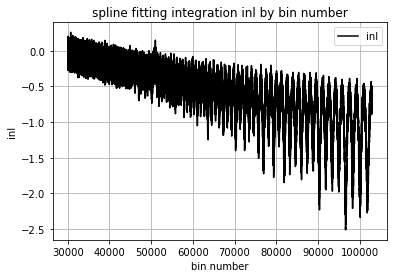

In [12]:
bins = 30000 + np.arange(0, len(intedges)-1)
intinl = examineinl(intedges, bins, "spline fitting integration")

## Spline fitting to countarr 

In [19]:
cscount = scipy.interpolate.CubicSpline(termbins[1:], termcountarr[1:])

In [21]:
startca = time.time()
edgescountarr = buildedges(cscount, termcountarr[1:]) #exclude 29999 to start the array at 30k
endca = time.time()
print("the runtime is:", endca - startca)

the runtime is: 39.90722632408142


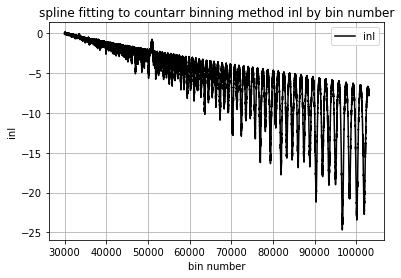

In [22]:
inlbinscount = 30000 + np.arange(0, len(edgescountarr)-1)
inlcount = examineinl(edgescountarr, inlbinscount, "spline fitting to countarr binning method")